In [1]:
from ddim import Diffusion, BayesPredictor, create_alpha_schedule, train_predictor

In [2]:
import os
import tempfile

import imageio
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm

In [3]:
def generate_data(batch_size):
    segments = [((0, 0), (0, 1)), ((0, 0.5), (0.5, 0.5)), ((0.5, 0), (0.5, 1)), ((1.0, 0), (1.0, 1.0))]
    points = []
    for segment in segments:
        p1 = np.array(segment[0])
        p2 = np.array(segment[1])
        for i in range(100):
            points.append(p1 + (p2 - p1) * (i / 99))
    points = np.stack(points)
    
    def generate_rejection_samples():
        samples = np.random.uniform(size=(batch_size, 1, 2)) * 2 - 0.5
        dists = np.sqrt(np.min(np.sum((samples - points[None]) ** 2, axis=-1), axis=1))
        return samples[dists < 0.05][:, 0]
    
    results = []
    while sum(len(x) for x in results) < batch_size:
        results.append(generate_rejection_samples())
    return (np.concatenate(results, axis=0)[:batch_size] - np.array([0.5, 0.5])) * 2.5

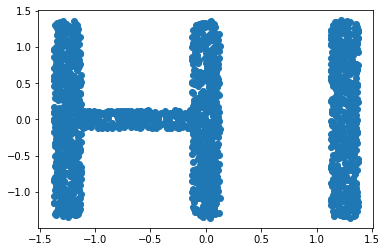

In [4]:
data = generate_data(2000)
plt.scatter(data[:, 0], data[:, 1])
plt.show()

In [5]:
diffusion = Diffusion(create_alpha_schedule(num_steps=100))
model = BayesPredictor(data)

In [13]:
def conditional_plot(axis, use_energy=False, stripe_size=10, num_samples=500, temp=1.0):
    assert axis in [0, 1], 'axis must be 0 (x) or 1 (y)'

    x_T = np.random.normal(size=(num_samples, 2))
    cond_mask = np.array([[True, False]] * len(x_T))
    cond_data = []
    colors = []
    for i in range(len(x_T)):
        j = (i // stripe_size) * stripe_size
        cond_data.append(np.array([3.0 * (j / len(x_T)) - 1.5, 0.0]))
        frac_red = int(255*j/len(x_T))
        colors.append(f"#{frac_red:02x}00ff")
    cond_data = np.array(cond_data)
    if axis == 1:
        cond_data = np.array(cond_data[:, ::-1])
        cond_mask = np.array(cond_mask[:, ::-1])

    if use_energy:
        samples = diffusion.ddpm_sample_cond_energy_inpaint(x_T, model, cond_data, cond_mask, temp=temp)
    else:
        samples = diffusion.ddpm_sample_cond(x_T, model, cond_data, cond_mask)
    plt.scatter(samples[:, 0], samples[:, 1], color=colors)
    plt.xlim(-1.5, 1.5)
    plt.ylim(-1.5, 1.5)
    plt.show()

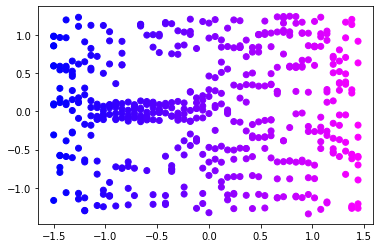

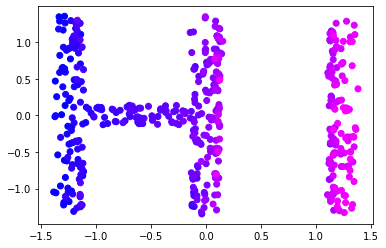

In [7]:
conditional_plot(0, use_energy=False)
conditional_plot(0, use_energy=True)

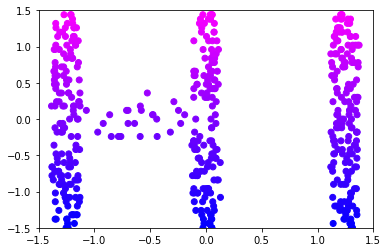

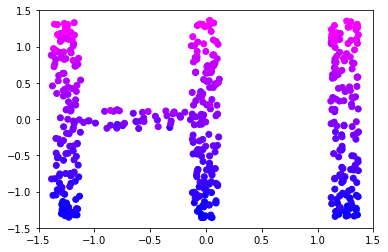

In [15]:
conditional_plot(1, use_energy=False)
conditional_plot(1, use_energy=True)

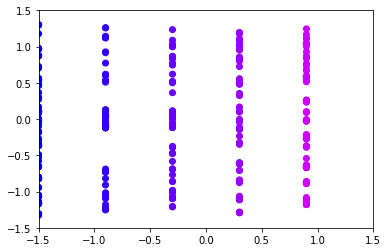

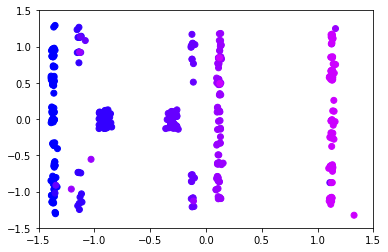

In [14]:
conditional_plot(0, use_energy=False, stripe_size=100)
conditional_plot(0, use_energy=True, stripe_size=100, temp=0.1)